<a href="https://colab.research.google.com/github/Pambao/MIP/blob/main/Problem_Set_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 1: Visualize dataset

<h3> Data: </h3> 

- 5000 frontal chest X-ray images with foreign objects presented and 5000 frontal chest X-ray images without foreign objects were filmed and collected from about 300 township hosiptials in China. 12 medically-trained radiologists with 1 to 3 years of experience annotated all the images. Each annotator manually annotates the potential foreign objects on a given chest X-ray presented within the lung field. Foreign objects were annotated with bounding boxes, bounding ellipses or masks depending on the shape of the objects. Support devices were excluded from annotation.

- The dataset contains:<br>
  - **training**: 4000 chest X-rays with foreign objects presented, 4000 chest X-rays without foreign object.<br>
  - **validation**: 500 chest X-rays with foreign objects presented, 500 chest X-rays without foreign object.<br>
  - There is no testset.<br>   

<h3> Annotation: </h3>

- Annotations are provided object-level for each image,  which indicate the rough location of each foreign object using a closed shape.<br>
- Annotations are provided in csv files and a csv example is shown below.<br>

| image_id |  annotations  |
|------|------|
|00001.jpg |object_type x1 y1 x2 y2;       object_type x1 y1 x2 y2;...| 
|00002.jpg|object_type x1 y1 x2 y2|

- Three type of shapes are used namely retangle, ellipse and polygon. ```0```, ```1```, ```2``` as ```object_type``` are used respectedly




In [ ]:
! pip install xlrd

In [ ]:
import csv
import os
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw, ImageFont

In [ ]:
# This function used to draw contour of object to visualize
def draw_object(image, annotations):
  labels = {0: 'rectangle', 1: 'elispe', 2:'polygon'}
  contour_color = (0, 255, 0)
  width = 20
  draw = ImageDraw.Draw(image, mode = 'RGB')
  for annotation in annotations.split(';'):
    annotation = list(map(int, annotation.split(' ')))
    if annotation[0] == 0:
      draw.rectangle(annotation[1:], outline=contour_color, width=width)
    elif annotation[0] == 1:
      draw.ellipse(annotation[1:], outline=contour_color, width=width)
    elif annotation[0] == 2:
      annotation.append(annotation[1])
      annotation.append(annotation[2])
      draw.line(annotation[1:], fill=contour_color, width=width)
    draw.text(
        (annotation[1], annotation[2] - width), 
        labels.get(annotation[0]),
        fill = 'red',
        font=ImageFont.truetype('/content/drive/MyDrive/MIP Resource/arial.ttf', 100)
        )

8000 pictures in /content/drive/MyDrive/MIP Resource/ChestXrayDataSet/customDataSet/images/train
1000 pictures in /content/drive/MyDrive/MIP Resource/ChestXrayDataSet/customDataSet/images/dev


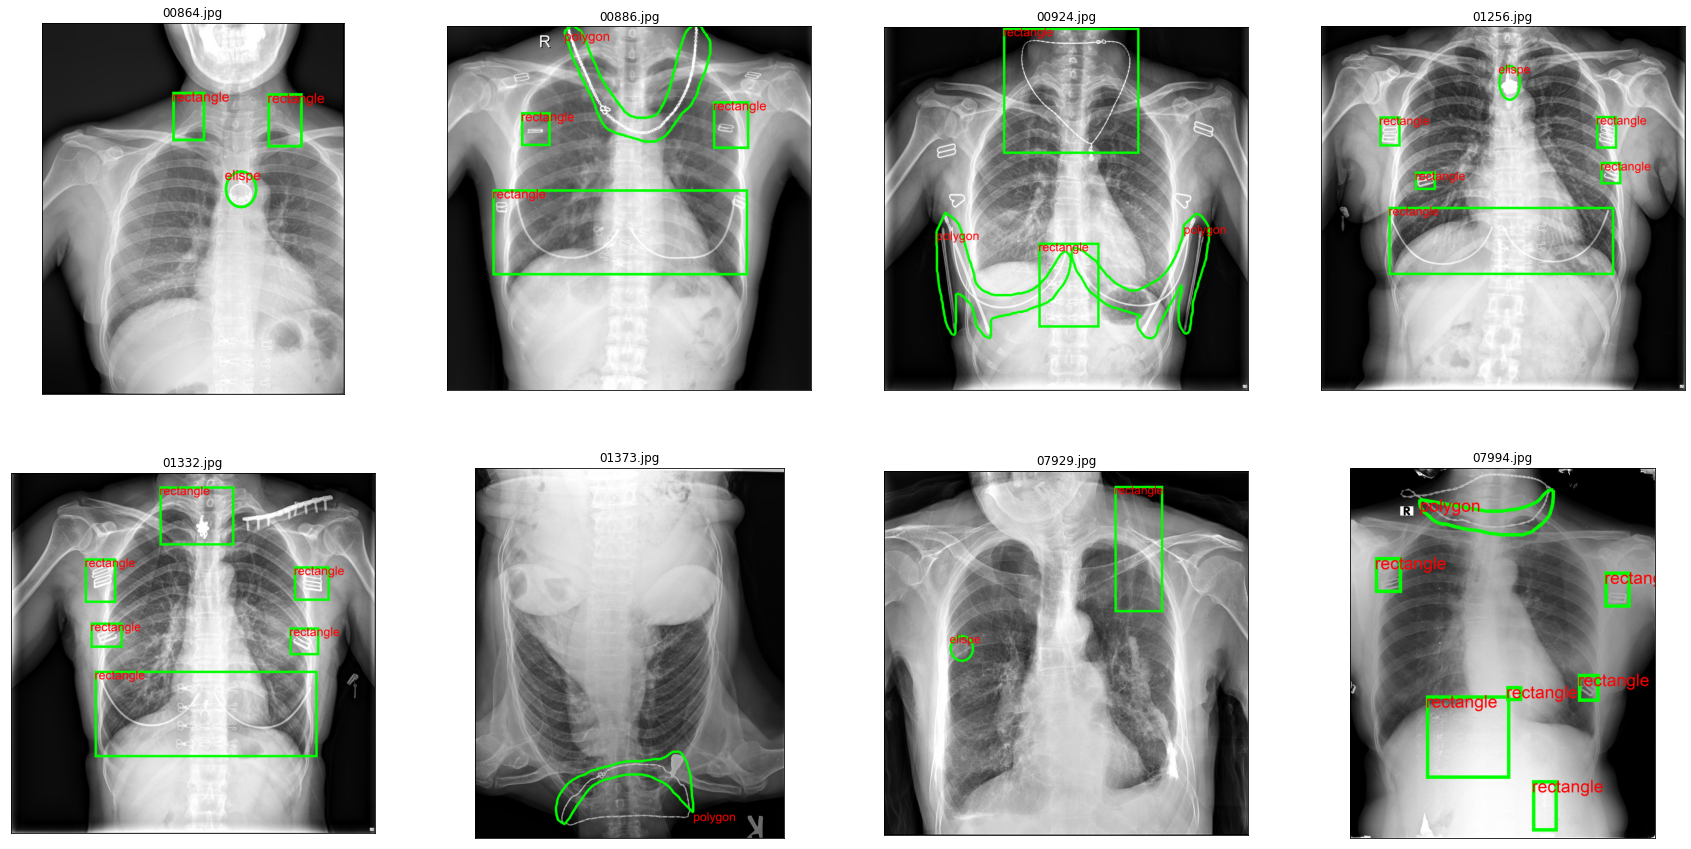

In [ ]:
DIRECTORY = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/object-CXR/'
IMAGES_DIRECTORY = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/customDataSet/images/'
SUBDIR = ['train', 'dev']

for dir in SUBDIR:
  print(f'{len(os.listdir(IMAGES_DIRECTORY + dir))} pictures in {IMAGES_DIRECTORY}{dir}')

samples = [864, 886, 924, 1256, 1332, 1373, 7929, 7994]
fig, axs = plt.subplots(2, 4, subplot_kw=dict(xticks=[], yticks=[]), figsize=(30, 15))
axs = list(axs[0]) + list(axs[1])

file = open(DIRECTORY + 'train.csv')
csv_file = list(csv.reader(file))

# Iterate images through sample list and get its annotations
for sample, ax in zip(samples, axs):
  line = csv_file[sample]
  image_name = line[0]
  annotations = line[1]
  image = Image.open(IMAGES_DIRECTORY + 'train/' + image_name).convert('RGB')
  draw_object(image, annotations)
  ax.set_title(image_name)
  ax.imshow(image)

## Step 2: Build custom dataset

In [ ]:
import csv
import os
import sys

from pathlib import Path
from PIL import Image

In [ ]:
% cd /content/drive/MyDrive/MIP Resource/ChestXrayDataSet

/content/drive/MyDrive/MIP Resource/ChestXrayDataSet


In [ ]:
!mkdir customDataSet

In [ ]:
DIRECTORY = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/object-CXR/'
IMAGE_DIR = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/customDataSet/images/'
CATEGORIES = ['train', 'dev']

lables_path = Path(f'{DIRECTORY}labels')
lables_path.mkdir(parents=True, exist_ok=True)

for category in CATEGORIES:
  lables_path = Path(f'{DIRECTORY}labels/{category}')
  lables_path.mkdir(parents=True, exist_ok=True)

  file = open(DIRECTORY + category + '.csv')
  csv_file = list(csv.reader(file))
  counter = 0
  for line in csv_file[1:]:
    image_id = (line[0].split('.'))[0]
    sys.stdout.write("\rFile %s %i" %(image_id, counter))
    sys.stdout.flush()

# If annotation exists
    if(line[1] != ''):
      counter += 1

      image_lable_file = f'{image_id}.txt'
      labels_file = open(f'{DIRECTORY}labels/{category}/{image_lable_file}', mode = 'w')
      image = Image.open(IMAGE_DIR + category + '/' + image_id +'.jpg')  
      size = image.size
      annotations = line[1].split(';')
      for annotation in annotations:
        #class_index = list(map(int, annotation.split(' ')))[0]
        class_index = 0
        annotation = list(map(int, annotation.split(' ')))[1:]
        list_x = []
        list_y = []
        for index, val in enumerate(annotation):
            if index % 2 == 0:
              list_x.append(val)
            else:
              list_y.append(val)
        max_x = max(list_x)
        min_x = min(list_x)
        max_y = max(list_y)
        min_y = min(list_y)
        width = (max_x - min_x) / size[0]
        height =( max_y - min_y) / size[1]
        center_x = max_x / size[0] - width / 2
        center_y = max_y / size[1] - height / 2

        formated_annotation = f'{class_index} {center_x} {center_y} {width} {height}\n' 
        labels_file.write(formated_annotation)
      labels_file.close()

File 09000 499

In [ ]:
f = open('/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/object-CXR/labels/train/07992.txt', 'r')
for line in f:
  print(line)
import os
print(len(os.listdir('/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/object-CXR/labels/train/')))

0 0.5182730923694778 0.7559082892416226 0.7875502008032128 0.23209876543209876

0 0.20301204819277108 0.5883597883597884 0.0606425702811245 0.04938271604938271

0 0.1634538152610442 0.41410934744268074 0.10281124497991968 0.12839506172839507

0 0.7558232931726907 0.5869488536155203 0.06746987951807229 0.05008818342151675

0 0.9078313253012048 0.39012345679012345 0.08795180722891566 0.12839506172839507

4000


In [ ]:
import os
f = open('/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/preparedDataSet/labels/train/07992.txt', 'r')
separator = ' '
for line in f:
  annotation = line.split(separator)
  annotation[0] = '1'
  print(separator.join(annotation))

1 0.3937751004016064 0.11604938271604938 0.7875502008032128 0.23209876543209876

1 0.03032128514056225 0.024691358024691357 0.0606425702811245 0.04938271604938271

1 0.05140562248995984 0.06419753086419754 0.10281124497991968 0.12839506172839507

1 0.033734939759036145 0.025044091710758377 0.06746987951807229 0.05008818342151675

1 0.04397590361445783 0.06419753086419754 0.08795180722891566 0.12839506172839507



In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def change_label(path):
  f = open(path, mode = 'r')
  content = []
  separator = ' '
  for line in f:
    content.append(line)
  f.close()
  f = open(path, mode = 'w')
  for line in content:
    line = line.split(separator)
    line[0] = '0'
    line = separator.join(line)
    f.write(line)
  f.close()

DIR = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/preparedDataSet/labels/'

CATEGORIES = ['dev', 'train']
for category in CATEGORIES:
  path = f'{DIR}{category}/'
  for image in os.listdir(path):
    change_label(path + image)

In [ ]:
print(len(os.listdir('/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/preparedDataSet/labels/dev')))

500


In [ ]:
from shutil import copyfile
from pathlib import Path
import csv
DIRECTORY = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/object-CXR/'
IMAGE_DIR = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/customDataSet/images/'
LABEL_DIR = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/customDataSet/labels/'
NEW_DIR = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/preparedDataSet/'
CATEGORIES = ['train', 'dev']

lables_path = Path(f'{NEW_DIR}labels')
lables_path.mkdir(parents=True, exist_ok=True)

image_path = Path(f'{NEW_DIR}images')
image_path.mkdir(parents=True, exist_ok=True)

for category in CATEGORIES:
  cate_path = Path(f'{NEW_DIR}labels/{category}')
  cate_path.mkdir(parents=True, exist_ok=True)
  cate_path = Path(f'{NEW_DIR}images/{category}')
  cate_path.mkdir(parents=True, exist_ok=True)

  file = open(DIRECTORY + category + '.csv')
  csv_file = list(csv.reader(file))
  for line in csv_file[1:]:
    image_id = (line[0].split('.'))[0]
    if(line[1] != ''):
      image_root = f'{IMAGE_DIR}{category}/{image_id}.jpg'
      txt_root = f'{LABEL_DIR}{category}/{image_id}.txt'
      image_des = f'{NEW_DIR}images/{category}/{image_id}.jpg'
      txt_des = f'{NEW_DIR}labels/{category}/{image_id}.txt'

      copyfile(image_root, image_des)
      copyfile(txt_root, txt_des)

In [ ]:
!sudo apt-get install tree

(2176, 2672)
(2802, 2801)
(2983, 2978)
(2972, 2972)
(2974, 2941)
(2552, 3065)
(3072, 3072)
(1760, 2140)


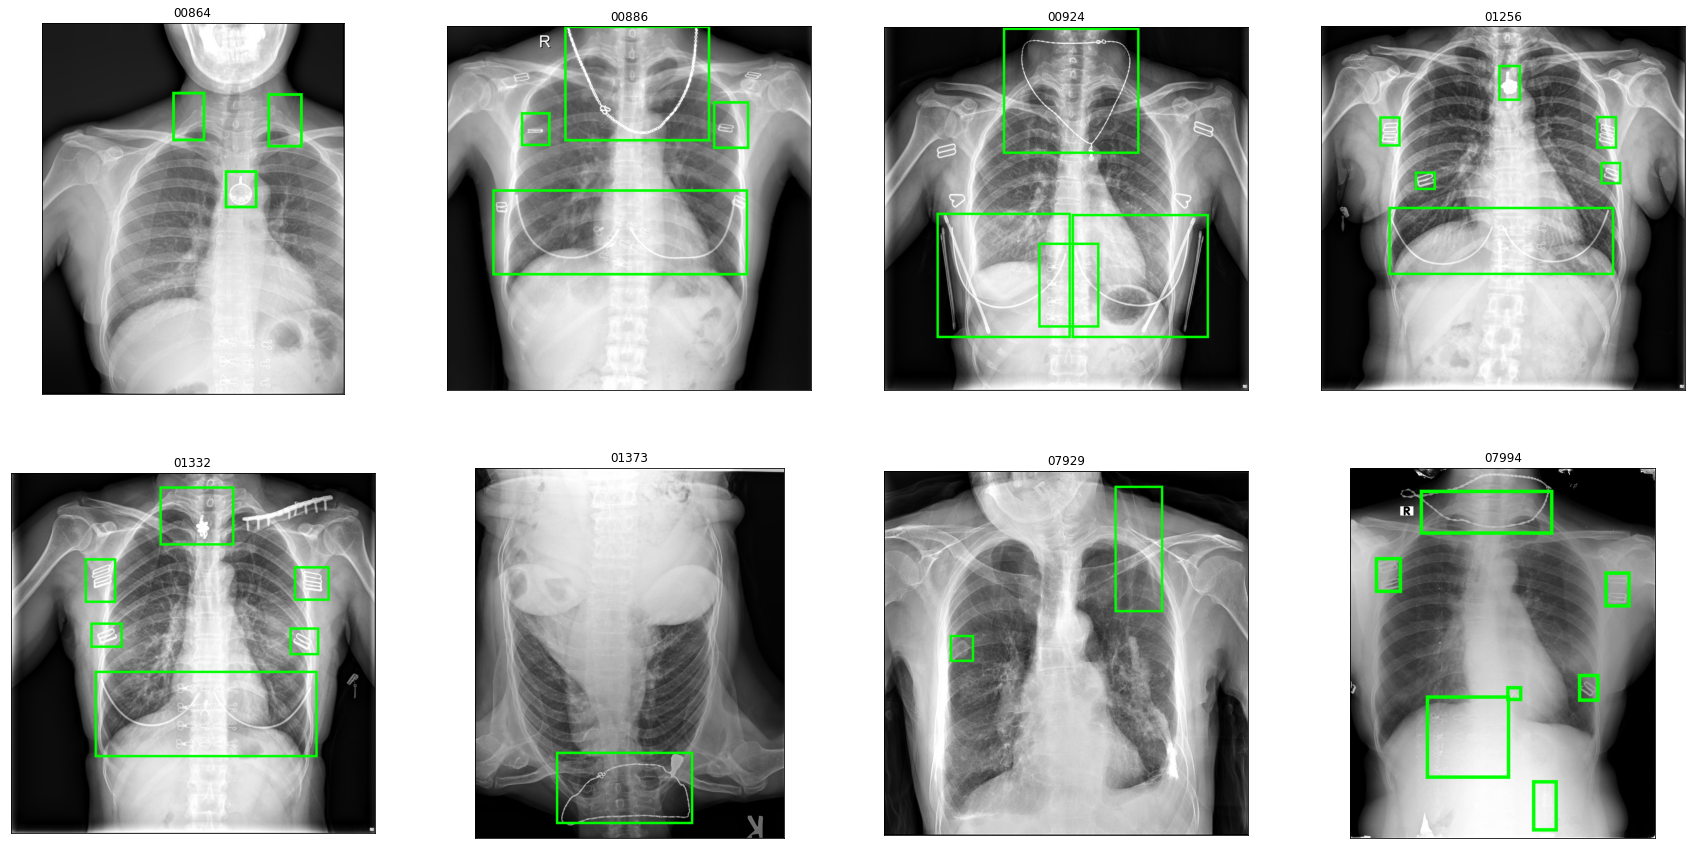

In [ ]:
DIRECTORY = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/preparedDataSet/labels/train/'
IMAGES_DIRECTORY = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/preparedDataSet/images/train/'
SUBDIR = ['train', 'dev']



samples = [864, 886, 924, 1256, 1332, 1373, 7929, 7994]
fig, axs = plt.subplots(2, 4, subplot_kw=dict(xticks=[], yticks=[]), figsize=(30, 15))
axs = list(axs[0]) + list(axs[1])


# Iterate images through sample list and get its annotations
for sample, ax in zip(samples, axs):
  f = open(DIRECTORY + '{:05}'.format(sample) + '.txt')
  image = Image.open(IMAGES_DIRECTORY + '{:05}'.format(sample) + '.jpg').convert('RGB')
  size = image.size
  #print(size)
  for line in f:
    line = list(map(float, line.split(' ')))
    width = line[3] * size[0]
    height = line[4] * size[1]
    x_min = line[1] * size[0] - width/2
    #print(line)
    x_max = line[1] * size[0] + width/2
    y_min = line[2] * size[1] - height/2
    y_max = line[2] * size[1] + height/2
    anno = [x_min,y_min,x_max,y_max]
    anno = list(map(int, anno))
    #print(anno)
    draw = ImageDraw.Draw(image, mode = 'RGB')
    contour_color = (0, 255, 0)
    draw.rectangle(anno, outline=contour_color, width=20)
  #draw_object(image, annotations)
  ax.set_title('{:05}'.format(sample))
  ax.imshow(image)

In [ ]:
!tree customDataSet -L 2

/content/drive/MyDrive/MIP Resource/ChestXrayDataSet
customDataSet
├── images
│   ├── dev
│   └── train
└── labels
    ├── dev
    └── train

6 directories, 0 files


## Step 3: Train model

In [1]:
%cd '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet'

/content/drive/MyDrive/MIP Resource/ChestXrayDataSet


In [ ]:
!git clone https://github.com/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [2]:
%cd yolov5/

/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/yolov5


In [3]:
! pip install -r requirements.txt

     |████████████████████████████████| 645kB 8.6MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!git checkout ec72eea62bf5bb86b0272f2e65e413957533507f

error: Your local changes to the following files would be overwritten by checkout:
	.gitignore
	README.md
	data/scripts/get_coco.sh
	requirements.txt
	utils/datasets.py
	utils/general.py
	weights/download_weights.sh
Please commit your changes or stash them before you switch branches.
Aborting


In [ ]:
!pip install thop
!pip install numpy --upgrade

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.5)


In [ ]:
!gdown --id 1ZycPS5Ft_0vlfgHnLsfvZPhcH6qOAqBO -O data/foreign.yaml
!gdown --id 1czESPsKbOWZF7_PkCcvRfTiUUJfpx12i -O models/yolov5x.yaml

Downloading...
From: https://drive.google.com/uc?id=1ZycPS5Ft_0vlfgHnLsfvZPhcH6qOAqBO
To: /content/drive/My Drive/MIP Resource/ChestXrayDataSet/yolov5/data/foreign.yaml
100% 172/172 [00:00<00:00, 534kB/s]
Downloading...
From: https://drive.google.com/uc?id=1czESPsKbOWZF7_PkCcvRfTiUUJfpx12i
To: /content/drive/My Drive/MIP Resource/ChestXrayDataSet/yolov5/models/yolov5x.yaml
100% 1.58k/1.58k [00:00<00:00, 1.96MB/s]


In [ ]:
!python train.py --img 608 --batch 8 --epochs 60 \
--data ./data/foreign.yaml --cfg ./models/yolov5x.yaml --weights yolov5x.pt \
--name yolov5x_foreign_object --cache

github: ⚠️ WARNING: code is out of date by 2 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 v4.0-30-gb1cf25d torch 1.7.0+cu101 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Namespace(adam=False, batch_size=8, bucket='', cache_images=True, cfg='./models/yolov5x.yaml', data='./data/foreign.yaml', device='', epochs=60, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[608, 608], local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='yolov5x_foreign_object', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5x_foreign_object14', single_cls=False, sync_bn=False, total_batch_size=8, weights='yolov5x.pt', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard with "tensorboard --logdir runs/train

In [ ]:
%cd yolov5/

/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/yolov5


In [ ]:
!nvidia-smi

Wed Jan 20 10:32:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!dir

data	    hubconf.py	__pycache__	  runs	    tutorial.ipynb  yolov5l.pt
detect.py   LICENSE	README.md	  test.py   utils	    yolov5s.pt
Dockerfile  models	requirements.txt  train.py  weights	    yolov5x.pt


In [ ]:
import os
DIR = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/preparedDataSet/labels/'
f = open(DIR +'train/' + '00059.txt', mode = 'r')
for line in f:
  print(line)

0 0.16416845110635261 0.11906461977865049 0.32833690221270523 0.23812923955730098



## Step 5: Visualize the result

In [ ]:
import csv
import os
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw, ImageFont

In [ ]:
!python detect.py --weights '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/yolov5/runs/train/5x_512_4_70/weights/best.pt'\
  --img 512 --conf 0.2 --save-txt --save-conf  --source '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/customDataSet/images/dev'

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='', exist_ok=False, img_size=520, iou_thres=0.45, name='exp', project='runs/detect', save_conf=True, save_txt=True, source='/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/preparedDataSet/images/dev', update=False, view_img=False, weights=['/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/yolov5/runs/train/5x_512_4_70/weights/best.pt'])
YOLOv5 v4.0-30-gb1cf25d torch 1.7.0+cu101 CPU

Fusing layers... 
Model Summary: 476 layers, 87198694 parameters, 0 gradients, 217.1 GFLOPS
image 1/500 /content/drive/MyDrive/MIP Resource/ChestXrayDataSet/preparedDataSet/images/dev/08001.jpg: 544x448 1 objects, Done. (1.759s)
image 2/500 /content/drive/MyDrive/MIP Resource/ChestXrayDataSet/preparedDataSet/images/dev/08004.jpg: 544x512 1 objects, Done. (1.955s)
image 3/500 /content/drive/MyDrive/MIP Resource/ChestXrayDataSet/preparedDataSet/images/dev/08008.jpg: 544x544 2 objects, Done. (2.041s)
image 4/500 /content

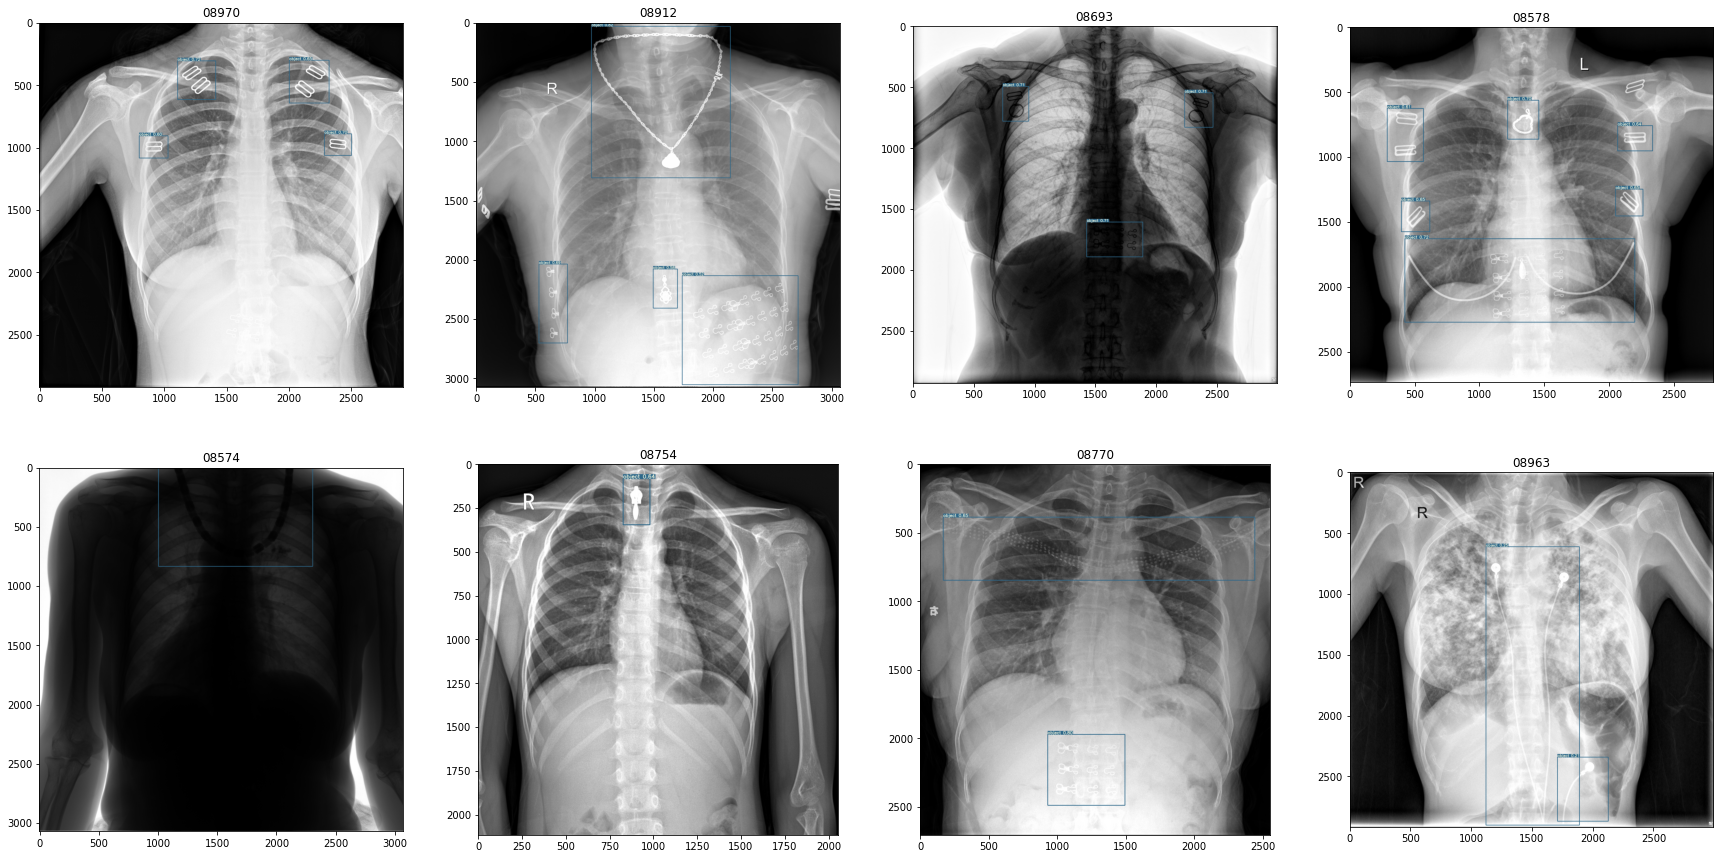

In [16]:
from PIL import Image

import matplotlib.pyplot as plt

TEST_DIR = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/yolov5/runs/detect/exp25/'
samples = ['08970', '08912', '08693', '08578', '08574', '08754', '08770', '08963']

fig, axs = plt.subplots(2, 4 ,figsize=(30, 15))
axs = list(axs[0]) + list(axs[1])

for img_name, ax in zip(samples, axs):
  img_path = TEST_DIR + img_name + '.jpg'
  image = Image.open(img_path)
  ax.set_title(img_name)
  ax.imshow(image)

## Calculate AUC and ROC

In [18]:
def cal_ioc(box1, box2):
  xA = max(box1[0], box2[0])
  yA = max(box1[1], box2[1])
  xB = min(box1[2], box2[2])
  yB = min(box1[3], box2[3])

  intersect_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
  box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
  union_area = float ((box1_area + box2_area) - intersect_area)

  return intersect_area / union_area

def anno_to_box(anno):
  box = []

  anno_half_x = anno[3] / 2
  anno_half_y = anno[4] / 2
  anno_x_min = anno[1] - anno_half_x
  anno_x_max = anno[1] + anno_half_x
  anno_y_min = anno[2] - anno_half_y
  anno_y_max = anno[2] + anno_half_y


  box.append(anno_x_min)
  box.append(anno_y_min)
  box.append(anno_x_max)
  box.append(anno_y_max)

  return box

In [20]:
import os
import csv
import sys

from pathlib import Path

TARGET_DIR = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/yolov5/runs/detect/exp25/'
TEST_DIR = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/yolov5/runs/detect/exp25/labels/'
ORIGINAL_TEST_DIR = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/customDataSet/labels/dev/'

ioc_path = Path(f'{TARGET_DIR}/iou_csv')
ioc_path.mkdir(parents=True, exist_ok=True)
file = open(TARGET_DIR+ 'iou_csv/' + 'data.csv', mode='w')
file_writer = csv.writer(file, delimiter=' ')

counter = 0
total = len(os.listdir(TEST_DIR))
for image in os.listdir(TEST_DIR):
  detect_annotations_list = []
  original_annotations_list = []
  predictions = []

  detect_box_list = []
  original_box_list = []
  computed_labels = []

  with open(TEST_DIR + image, mode = 'r') as detect_annotations:
    for detect_annotation in detect_annotations:
      detect_annotations_list.append(detect_annotation)

  with open(ORIGINAL_TEST_DIR + image, mode = 'r') as original_annotations:
    for original_annotation in original_annotations:
      original_annotations_list.append(original_annotation)

  for annotation in detect_annotations_list:
    anno = annotation.split(' ')
    anno = list(map(float, anno))
    box = anno_to_box(anno)

    detect_box_list.append(box)
    predictions.append(anno[-1])

  for annotation in original_annotations_list:
    anno = annotation.split(' ')
    anno = list(map(float, anno))
    box = anno_to_box(anno)

    original_box_list.append(box)
    #print(detect_box_list)
    #print(original_box_list)
    #print(predictions)

  original_box_list_length = len(original_box_list)
  for pred_box, prediction in zip(detect_box_list, predictions):
    for index, ori_box in enumerate(original_box_list):
      iou = cal_ioc(pred_box, ori_box)
      #print(iou)
      if iou >= 0.5:
        computed_labels.append([1, prediction])
        break
      elif index == original_box_list_length - 1:
        computed_labels.append([0, prediction])

  for computed_label in computed_labels:
    file_writer.writerow(computed_label)

  sys.stdout.write("\r%i/%i" %(counter, total))
  sys.stdout.flush()
  counter += 1
  #break
file.close()

744/745

In [32]:
import os
import csv
import sys

from os import path
from pathlib import Path

TEST_DIR = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/yolov5/runs/detect/exp25/labels/'
ORIGINAL_DIR = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/object-CXR/dev.csv'
TARGET_DIR = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/yolov5/runs/detect/exp25/'

y = []
preds = []

file = open(ORIGINAL_DIR, mode = 'r')
csv_file = list(csv.reader(file))[1:]
file.close()

total = len(csv_file) - 1
counter = 0

for line in csv_file:
  image_id = line[0].split('.')[0]
  annotation = line[1]
  if(annotation == ''):
    y.append(0)
  else:
    y.append(1)
  
  detect_path = TEST_DIR + image_id + '.txt'
  if path.exists(detect_path):
    predictions = []
    with open(detect_path, mode = 'r') as detect_annotations:
      for detect_annotation in detect_annotations:
        anno = list(map(float, detect_annotation.split(' ')))
        predictions.append(anno[-1])
    #print(predictions)
    preds.append(max(predictions))
  else:
    preds.append(0)
  sys.stdout.write("\r%i/%i" %(counter, total))
  sys.stdout.flush()
  counter += 1

file = open(TARGET_DIR+ 'iou_csv/' + 'data.csv', mode='w')
file_writer = csv.writer(file, delimiter=' ')

for label,pred in zip(y, preds):
  file_writer.writerow([label, pred])

file.close()



999/999

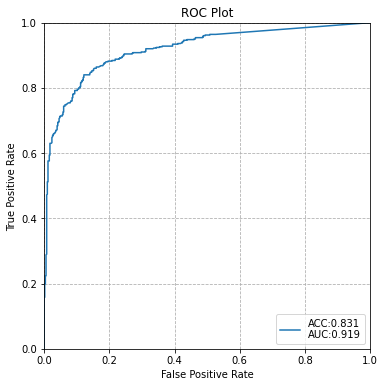

In [46]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import numpy as np
DATA_DIR = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/yolov5/runs/detect/exp25/iou_csv/data.csv'

file = open(DATA_DIR, mode = 'r')
reader = csv.reader(file)
content = list(reader)

y = []
preds = []
for line in content:
  y.append(line[0].split(' ')[0])
  preds.append(line[0].split(' ')[1])

y = list(map(int, y))
preds = list(map(float, preds))
y = np.array(y)
preds = np.array(preds)

#acc = ((preds >= .5) == y).mean()
auc = roc_auc_score(y, preds)
fpr, tpr, _ = roc_curve(y, preds)


fig, ax = plt.subplots(
    subplot_kw=dict(xlim=[0, 1], ylim=[0, 1], aspect='equal'),
    figsize=(6,6)
)
ax.set_title("ROC Plot")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
ax.plot(fpr, tpr, label=f'ACC:{acc:.03}\nAUC:{auc:.03}')
ax.legend(loc='lower right')
ax.grid(linestyle='dashed')



In [101]:
import os
import csv
import pandas

from os import path
from PIL import Image
TEST_DIR = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/yolov5/runs/detect/exp25/labels/'
TARGET_DIR = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/yolov5/runs/detect/exp25/'
IMAGE_DIR =  '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/customDataSet/images/dev/'

or_file = open(ORIGINAL_DIR, mode = 'r')
or_reader = list(csv.reader(or_file))[1:]
or_file.close()

lables_path = Path(f'{TARGET_DIR}froc_csv/')
lables_path.mkdir(parents=True, exist_ok=True)

colum1 = []
colum2 = []

image_ids = []
for id in os.listdir(IMAGE_DIR):
  id = int(id.split('.')[0])
  image_ids.append(id)
image_ids.sort()
#print(image_ids)

counter = 1
total = len(image_ids)

for id in image_ids:
  detect_path = f'{TEST_DIR}{id:05d}.txt'
  boxes = []
  if path.exists(detect_path):
    image = Image.open(f'{IMAGE_DIR}{id:05d}.jpg')
    size = image.size
    detect_contents = list(open(detect_path))

    for content in detect_contents:
      content = list(map(float, content.split(' ')))
      
      prediction = content[5]
      x_center = content[1]
      y_center = content[2]
      width = content[3]
      height = content[4]

      x_center = x_center * size[0]
      y_center = y_center * size[1]
      x_min = x_center - width / 2 * size[0]
      y_min = y_center - height / 2 * size[1]
      x_max = x_center + width / 2 * size[0]
      y_max = y_center + height / 2 * size[1]

      box = f'{prediction} {x_center} {y_center} {x_min} {y_min} {x_max} {y_max}'
      boxes.append(box)
    boxes = ';'.join(boxes)
    #file_writer.writerow([f'{id:05d}.jpg', boxes])
    colum2.append(boxes)
  else:
    colum2.append('')
  colum1.append(f'{id:05d}.jpg')
    
  sys.stdout.write("\r%i/%i" %(counter, total))
  sys.stdout.flush()
  counter += 1
loc_res = pandas.DataFrame({'image_name': colum1, 'prediction': colum2})
loc_res.to_csv(TARGET_DIR+ 'froc_csv/' + 'data.csv', columns=['image_name', 'prediction'], sep=',', index=None)

1000/1000

In [90]:
%cd '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet'

/content/drive/MyDrive/MIP Resource/ChestXrayDataSet


In [91]:
%cd yolov5/

/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/yolov5


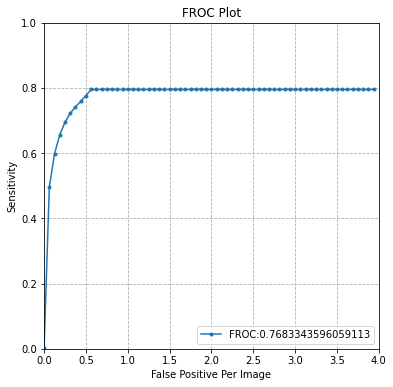

In [133]:
%run froc.py '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/object-CXR/dev.csv' \
'/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/yolov5/runs/detect/exp25/froc_csv/data.csv'